In [9]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

import ABC_train_test3
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean, variance , stdev
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Read the dataset 
df = pd.read_csv('quadratic_constant_variance_dataset.csv')
df = df.iloc[: , 1:]
df.head()

,X0,X1,X2,X3,X4,Y
0,0.671526,0.136384,0.410507,0.949903,0.642067,30.426311
1,0.323589,0.392485,0.448623,0.093304,0.774317,26.420313
2,0.731528,0.727359,0.819530,0.214921,0.862884,50.483146
3,0.175511,0.080082,0.185361,0.417887,0.800513,18.700592
4,0.505320,0.269499,0.580712,0.809964,0.713458,38.582332


In [3]:
n_features = 5
X_not_scaled = df.iloc[:,0:n_features]
Y_not_scaled = df.iloc[:,n_features]
X_not_scaled = X_not_scaled.to_numpy()
Y_not_scaled = Y_not_scaled.to_numpy()

# Data Pre-processing 
scaler = preprocessing.StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df.head())

# Get X and Y
X = df.iloc[:,0:n_features]
Y = df.iloc[:,n_features]

#Add Constant 
X = X.to_numpy()
Y = Y.to_numpy()

         X0        X1        X2        X3        X4         Y
0  0.619454 -1.227725 -0.332374  1.516425  0.511967 -0.331738
1 -0.572592 -0.362389 -0.202349 -1.438951  0.970680 -0.647607
2  0.825024  0.769115  1.062905 -1.019356  1.277876  1.249724
3 -1.079913 -1.417965 -1.100400 -0.319099  1.061541 -1.256300
4  0.050026 -0.777944  0.248237  1.033617  0.759590  0.311356


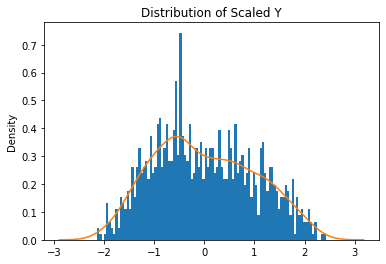

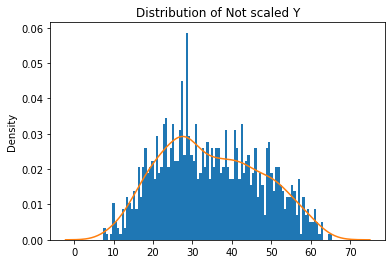

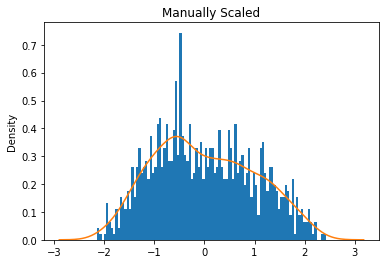

In [10]:
plt.hist(Y,bins=100,density=True)
sns.distplot(Y,hist=False)
plt.title("Distribution of Scaled Y")
plt.show()

plt.hist(Y_not_scaled,bins=100,density=True)
sns.distplot(Y_not_scaled,hist=False)
plt.title("Distribution of Not scaled Y")
plt.show()

Y_temp = (Y_not_scaled - mean(Y_not_scaled))/stdev(Y_not_scaled)
plt.hist(Y_temp,bins=100,density=True)
sns.distplot(Y_temp,hist=False)
plt.title("Manually Scaled")
plt.show()


In [5]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

In [6]:
# Training Parameters 
n_epochs = 5000
batch_size = 32
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Prior Model MAE 0.538400893999863


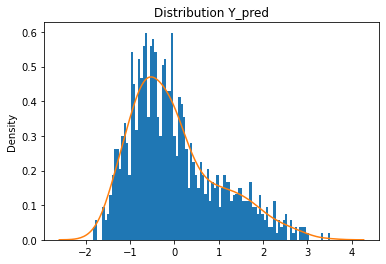

In [7]:
# Fit the prior model and pre - generator 
variance = 1 # Constant Variance 

# Exact Prior Model
y_pred = ABC_train_test3.quadratic_model(X)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Prior Model MAE : Error in data",mae)
print("Prior Model MAE", mae)

plt.hist(y_pred,bins=100,density=True)
sns.distplot(y_pred,hist=False)
plt.title("Distribution Y_pred")
plt.show()

In [12]:
from cmath import pi, sqrt


A = np.random.normal(0,1)
p = sqrt(2/3.14)
print(p)

(0.7980868844676221+0j)


##  mGAN 

In [33]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

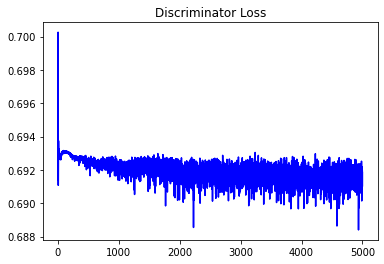

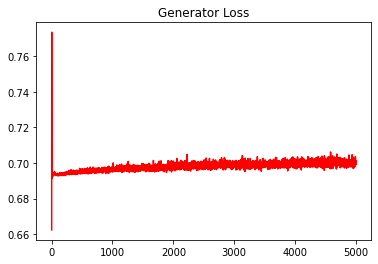

In [34]:
#Training the ABC_GAN 
ABC_train_test3.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [35]:
ABC_GAN1_metrics=ABC_train_test3.test_generator(gen,test_data,ABC_train_test3.linear_model,variance,"1",device)
# sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.09830167590640486


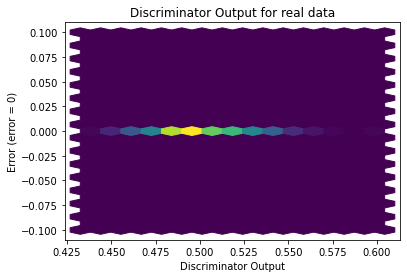

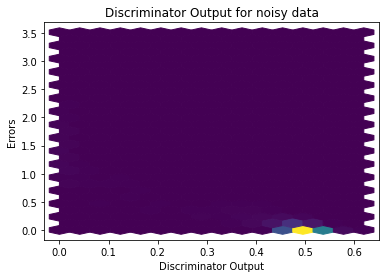

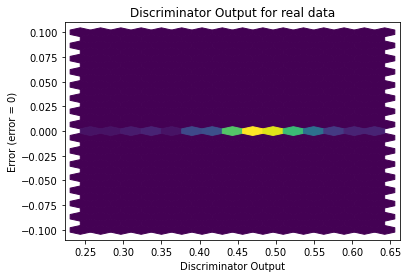

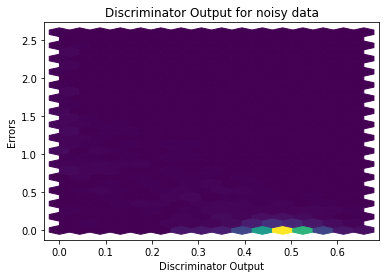

In [36]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [37]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


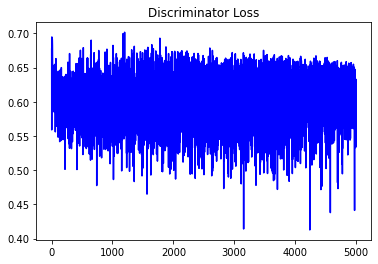

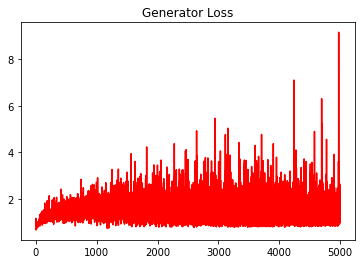

In [38]:
ABC_train_test3.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [39]:
ABC_GAN3_metrics=ABC_train_test3.test_generator(gen3,test_data,ABC_train_test3.linear_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.08572331334464252


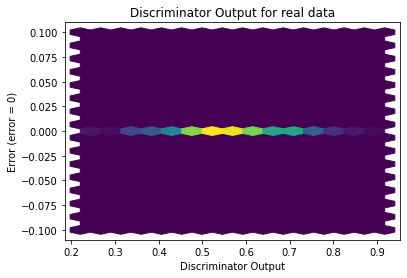

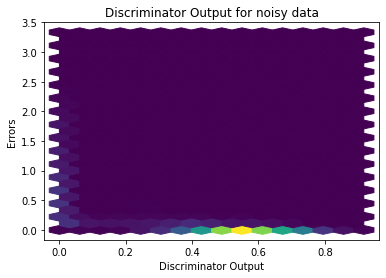

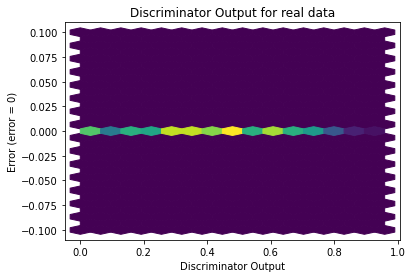

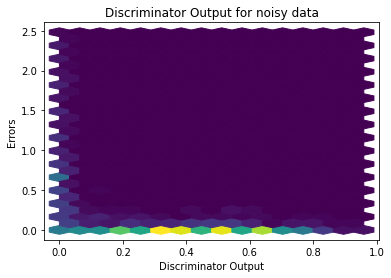

In [40]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [41]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.3482]], requires_grad=True)
